In [1]:
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
import utils

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/flypew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from utils import Imputer, MainFeatureExtractor, SimpleStatisticsExtractor, GeoFeatureExtractor, UserFeatureExtractor
from utils import BagOfWordsExtractor, TargetEncodingExtractor, ALSEmbeddingExtractor

In [3]:
path = "data/"
data_start = pd.read_csv(path + 'train_events.csv')
video_start = pd.read_csv(path + 'video_info_v2.csv')
targets_start = pd.read_csv(path + 'train_targets.csv')
test_events = pd.read_csv(path + 'test_events.csv')
sample_submission = pd.read_csv(path + 'subm.csv')

test_events.head(), sample_submission.head()

(             event_timestamp              region ua_device_type  \
 0  2024-06-01 15:26:44+03:00  Udmurtiya Republic        desktop   
 1  2024-06-01 12:25:29+03:00    Adygeya Republic     smartphone   
 2  2024-06-01 17:23:12+03:00    Astrakhan Oblast     smartphone   
 3  2024-06-01 15:37:37+03:00  Khakasiya Republic     smartphone   
 4  2024-06-01 21:30:11+03:00              Moscow     smartphone   
 
   ua_client_type    ua_os  ua_client_name  total_watchtime rutube_video_id  \
 0        browser  Windows  Yandex Browser             2593    video_212730   
 1     mobile app  Android          Rutube              960    video_235114   
 2     mobile app  Android          Rutube             4695     video_26520   
 3        browser  Android   Chrome Mobile             2490    video_465561   
 4     mobile app  Android          Rutube             1117    video_102934   
 
    viewer_uid  
 0       22206  
 1       34531  
 2       25830  
 3       14838  
 4       13718  ,
    viewer_

In [4]:
import warnings
warnings.filterwarnings('ignore')

events, features = Imputer().fit_transform(data_start, video_start, targets_start)
test_events, test_features = Imputer().fit_transform(test_events, video_start, sample_submission)
print(test_features.shape)

for extractor in [MainFeatureExtractor(), ALSEmbeddingExtractor(), BagOfWordsExtractor(), SimpleStatisticsExtractor(), GeoFeatureExtractor(), UserFeatureExtractor()]:
    events, features = extractor.fit_transform(events, features)
    test_events, test_features = extractor.transform(test_events, test_features)
    print(test_features.shape)

features.shape, test_features.shape

Applying Imputer...
Applying Imputer...
(60004, 4)
Applying MainFeatureExtractor...
(60004, 38)
Applying ALSEmbeddingExtractor...
Applying ALSEmbeddingExtractor...
(60004, 102)
Applying BagOfWords extractor...


In [34]:
test_features.head()

,viewer_uid,travel_count,has_app_installed,has_other,has_android,has_windows,has_mac,has_ios,has_ipados,uses_atom,...,category_Здоровье_viewtime,category_Здоровье_views,category_Строительство и ремонт_viewtime,category_Строительство и ремонт_views,category_Охота и рыбалка_viewtime,category_Охота и рыбалка_views,category_Дизайн_viewtime,category_Дизайн_views,category_Недвижимость_viewtime,category_Недвижимость_views
0,0,1,1,1,0,0,0,0,0,0,...,0.050628,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,0,0,0,0,1,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
class CatboostEstimator:
    """
    Класс для обучения Catboost
    """

    def fit(self, X, y, ids, n_splits, cat_features, score):
        """
        Разбивает данные на k фолдов со стратификацией и обучает n_splits катбустов
        """
        self.one_model = False
        self.models = []
        scores = []
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        for ind, (train_index, val_index) in enumerate(skf.split(X, y)):
            X_train = X.loc[train_index]
            y_train = y.loc[train_index]
            X_val = X.loc[val_index]
            y_val = y.loc[val_index]

            # train_idx = ids.loc[train_index]
            # train_idx.name = 'viewer_uid'

            # y_train_idx = y_train.copy()
            # y_train_idx.index = train_idx
            # X_train['viewer_uid'] = train_idx
            # val_idx = ids.loc[val_index]
            # val_idx.name = 'viewer_uid'
            # X_val['viewer_uid'] = val_idx
            # if y.name == 'age_class':
            #     target_enc_ext = utils.TargetEncodingExtractor()
            # else:
            #     target_enc_ext = utils.TargetEncodingExtractorSex()                
            # events_filtered_train = pd.merge(events, train_idx, on='viewer_uid', how='inner')
            # target_enc_ext.fit(events_filtered_train, pd.merge(X_train, y_train_idx, on='viewer_uid', how='inner'))
            # events_filtered_test = pd.merge(events, val_idx, on='viewer_uid', how='inner')

            # X_train = target_enc_ext.transform(events_filtered_train, X_train).drop(columns=['viewer_uid'])
            # X_val = target_enc_ext.transform(events_filtered_test, X_val).drop(columns=['viewer_uid'])

            model = CatBoostClassifier(cat_features=cat_features, verbose=500, iterations=1000)
            model.fit(X_train, y_train, verbose=500, eval_set=(X_val, y_val))
            
            self.models.append(model)
            y_pred = model.predict(X_val)
            scores.append(score(y_val, y_pred))
            print(f'model {ind}: score = {round(scores[-1], 4)}')
        
        scores = np.array(scores)
        print(f'mean score = {scores.mean().round(4)}, std = {scores.std().round(4)}')
        print(f'overall score = {(scores.mean() - scores.std()).round(4)}')
            
    
    def fit_select_features(self, X, y, cat_features, to_drop):
        """
        Обучает один катбуст и выполняет elect features
        """
        self.one_model = True
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        self.model = CatBoostClassifier(cat_features=cat_features, verbose=150, iterations=2000)
        
        self.model.select_features(X_train, y_train, verbose=500, eval_set=(X_val, y_val), steps=10,
                                  num_features_to_select=30, features_for_select=X.columns,
                                  algorithm='RecursiveByLossFunctionChange', train_final_model=True)

    def predict(self, X, cnt_classes):
        if self.one_model:
            return self.model.predict_proba(X)
        
        y_pred = np.zeros((X.shape[0], cnt_classes))

        for model in self.models:
            y_pred += model.predict_proba(X)
        y_pred /= cnt_classes
        y_pred = np.argmax(y_pred, axis=1)
        
        return y_pred

In [24]:
from sklearn.metrics import f1_score, accuracy_score

def score_sex(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


def score_age(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

In [25]:
cat_features = []
for i, col in enumerate(features.columns):
    if features[col].dtype in ['object', 'category']:
        cat_features.append(col)
        
cat_features

['region']

In [26]:
catboost_sex = CatboostEstimator()
catboost_age = CatboostEstimator()

features_to_drop = [
    'viewer_uid',
    'age'
]

target_sex = 'sex'
target_age = 'age_class'

print('Sex model\n')

ids = features.reset_index()['viewer_uid']
ids.name = 'viewer_uid'
y_sex = features[target_sex]
y_sex.name = target_sex

y_age = features[target_age]
y_age.name = target_age

catboost_sex.fit(features.drop(columns=features_to_drop + [target_sex] + [target_age]),
                 y_sex,
                 ids,
                 n_splits=2,
                 cat_features=cat_features,
                 score=score_sex)

print('\n\n\nAge model\n')

catboost_age.fit(features.drop(columns=features_to_drop + [target_sex] + [target_age]),
                 y_age,
                 ids,
                 n_splits=2,
                 cat_features=cat_features,
                 score=score_age)

Sex model

Learning rate set to 0.096297
0:	learn: 0.6672121	test: 0.6668080	best: 0.6668080 (0)	total: 51.1ms	remaining: 51.1s
500:	learn: 0.4544553	test: 0.4930302	best: 0.4930102 (497)	total: 19.3s	remaining: 19.2s
999:	learn: 0.4190641	test: 0.4930771	best: 0.4924765 (794)	total: 38s	remaining: 0us

bestTest = 0.4924764672
bestIteration = 794

Shrink model to first 795 iterations.
model 0: score = 0.7557
Learning rate set to 0.096297
0:	learn: 0.6659424	test: 0.6665064	best: 0.6665064 (0)	total: 49.8ms	remaining: 49.7s
500:	learn: 0.4515871	test: 0.4979782	best: 0.4979782 (500)	total: 19.4s	remaining: 19.3s
999:	learn: 0.4166697	test: 0.4976818	best: 0.4972181 (802)	total: 1m 7s	remaining: 0us

bestTest = 0.4972180851
bestIteration = 802

Shrink model to first 803 iterations.
model 1: score = 0.7518
mean score = 0.7538, std = 0.002
overall score = 0.7518



Age model

Learning rate set to 0.118144
0:	learn: 1.3447752	test: 1.3451757	best: 1.3451757 (0)	total: 208ms	remaining: 3m 28

In [27]:
age_prediction = catboost_age.predict(test_features.drop(columns=features_to_drop + [target_sex] + [target_age]), cnt_classes=4)
sex_prediction = catboost_sex.predict(test_features.drop(columns=features_to_drop + [target_sex] + [target_age]), cnt_classes=2)

sample_submission.loc[test_features.viewer_uid, 'age_class'] = age_prediction
sample_submission.loc[test_features.viewer_uid, 'sex'] = sex_prediction
sample_submission['sex'] = sample_submission['sex'].map({0: 'male', 1: 'female'})
sample_submission

,viewer_uid,age,sex,age_class
0,14416,39,female,3
1,5190,12,male,3
2,8887,23,male,2
3,55417,18,male,2
4,8980,48,male,1
...,...,...,...,...
59999,16343,44,male,3
60000,47183,26,female,3
60001,23370,58,male,3
60002,12750,22,male,3


In [32]:
sample_submission.sex.value_counts()

sex
male      39720
female    20284
Name: count, dtype: int64

In [28]:
sample_submission.to_csv('submission.csv', index=False)

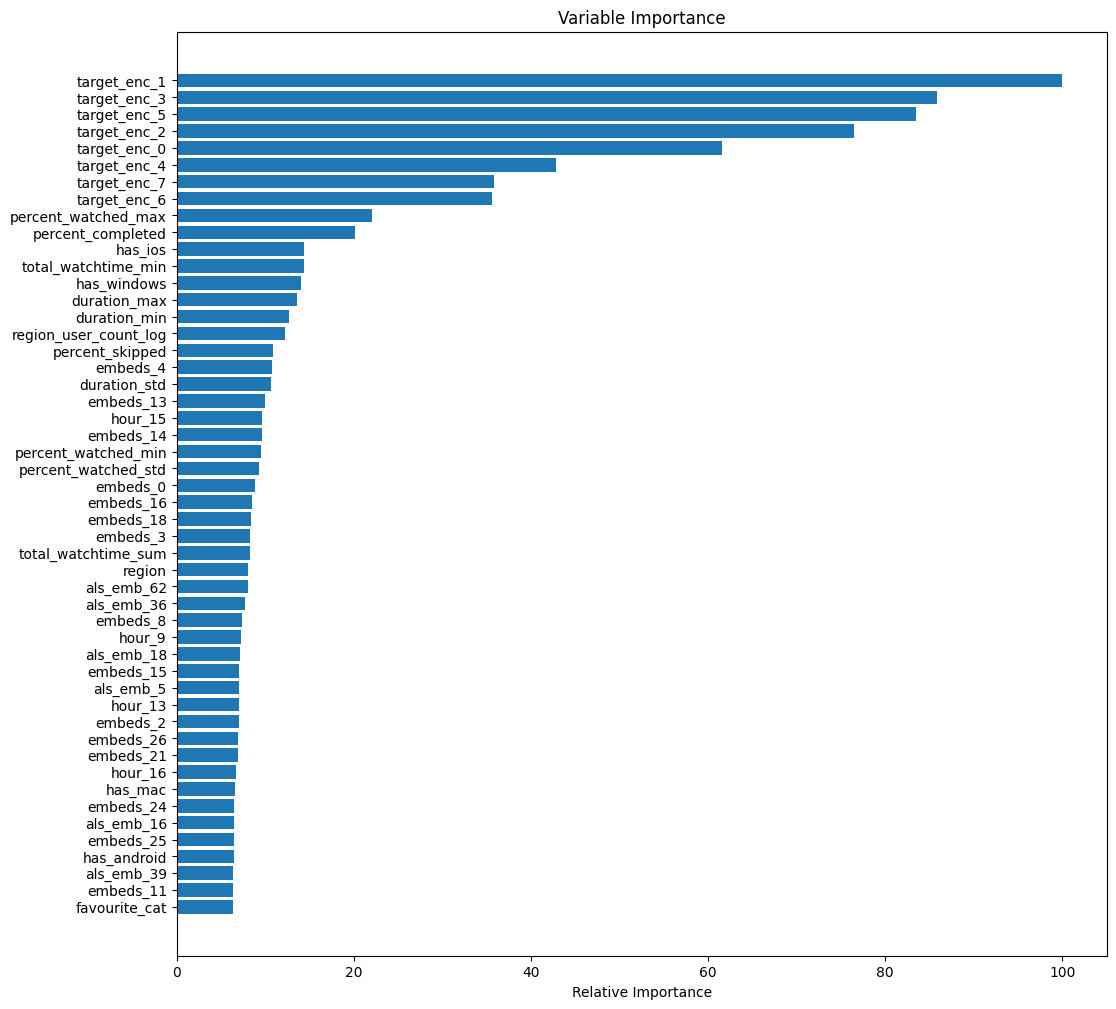

In [16]:
def plot_importance(model, features, top=50):
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    cols = features.columns.to_list()
    cols = [f"target_enc_{i}" for i in range(len(sorted_idx) - len(cols))] + cols
    cols = np.array(cols)

    plt.figure(figsize=(12, 12))
    plt.barh(pos[-top:], feature_importance[sorted_idx][-top:], align='center')
    plt.yticks(pos[-top:], cols[sorted_idx][-top:])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
plot_importance(catboost_age.models[0], features.drop(columns=features_to_drop + [target_sex] + [target_age]))

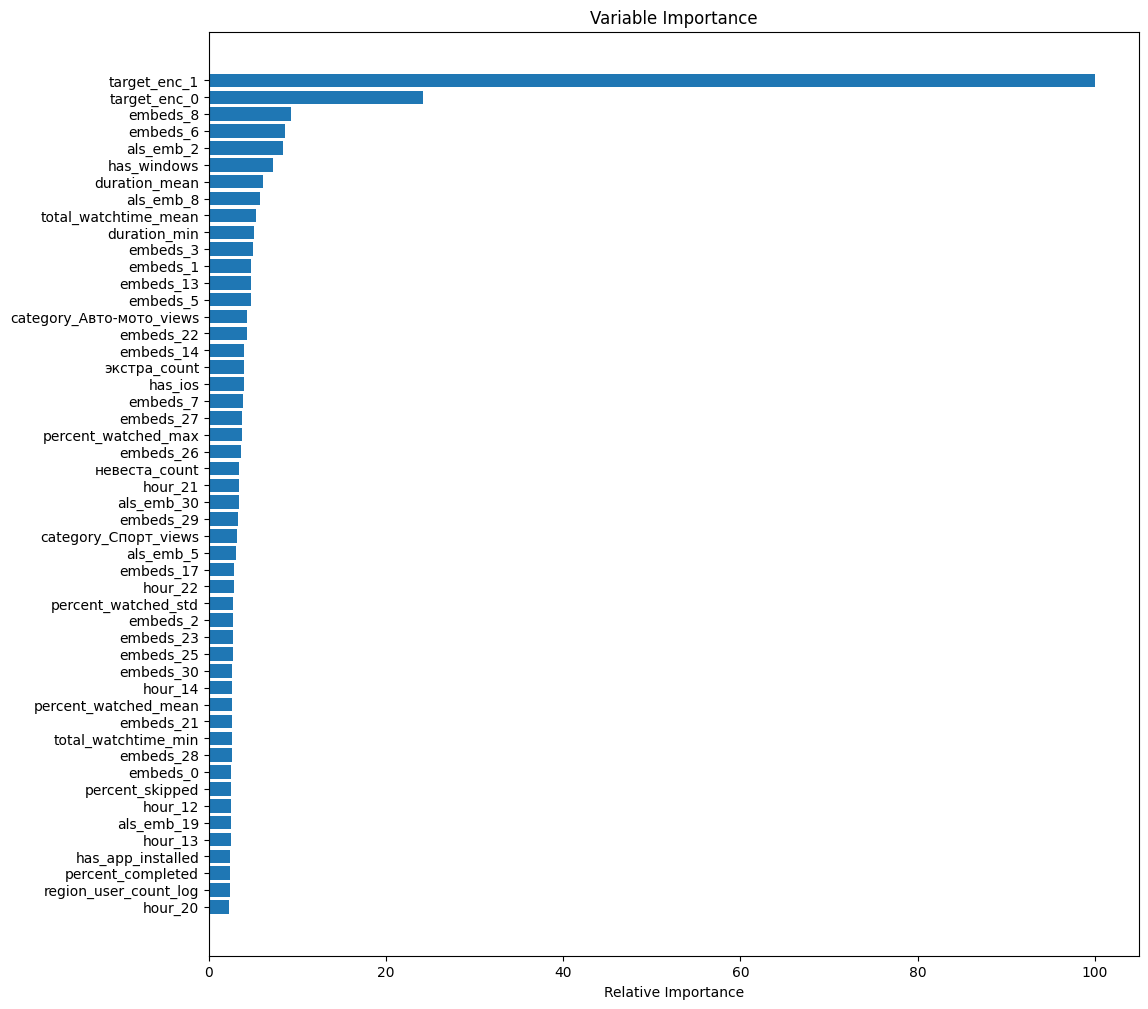

In [17]:
plot_importance(catboost_sex.models[0], features.drop(columns=features_to_drop + [target_sex] + [target_age]))